In [1]:
import os, sys
import pandas as pd
import numpy as np
import xarray as xr
import math
from itertools import product
from datetime import datetime, timedelta
import argparse
import logging
from scipy.special import gamma, factorial #gamma function
from scipy.stats import skew
from scipy.stats import norm
sys.path.append('/g/data/er4/zk6340/code/hydrodiy')
from hydrodiy.io import iutils
import errno
sys.path.append('/g/data/er4/zk6340/code/Script_CaRSA')
import grFor # generated python wrapper package
%matplotlib inline

/g/data/er4/vd5822/miniconda3/envs/awra-cms/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/g/data/er4/vd5822/miniconda3/envs/awra-cms/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
## dir folder path
dir_in = '/g/data/er4/zk6340/Hydro_projection/data_flood_scenario_qtot'
dir_out = '/g/data/er4/zk6340/code/Script_Hydro-projections'

# parameter
parameter = 'qtot'

# Which cluster
clusters = {'CS':1,'EC':2,'MB':4,'MN':5,'R':6,'SS':7,'SSWF':8,'WT':9}
which_cluster = clusters['R']

# return period
yT = 100

# historical period
hist_st = '19760101'
hist_end = '20051231'

# projection period
yr_st = '20560101'
yr_end = '20851231'

# Participating GCMs, Bias correction approaches, Emission scenarios
gcms = ['CNRM-CERFACS-CNRM-CM5']
bias_corr = ['r240x120-MRNBC-AWAP']
emission = ['rcp45']
# gcms = ['CNRM-CERFACS-CNRM-CM5','CSIRO-BOM-ACCESS1-0','MIROC-MIROC5','NOAA-GFDL-GFDL-ESM2M']
# bias_corr = ['CSIRO-CCAM-r3355-r240x120-ISIMIP2b-AWAP','r240x120-ISIMIP2b-AWAP', 'r240x120-MRNBC-AWAP', 'r240x120-QME-AWAP']
# emission = ['rcp45','rcp85']

In [3]:
#Function to get to the historical/scenario file
def get_file(parameter,which_gcm,which_emission,which_bias_corr, which_metric, yr_end, yr_st):
    base_filename = '%s_AUS-5_%s_%s_r1i1p1_%s_%s_%s-%s.nc'%(parameter,which_gcm,which_emission,which_bias_corr,which_metric,yr_end,yr_st)
    return(base_filename)

In [4]:
#Function to get percentage change for 'Mean' and 'Max'
def percentage_change(parameter, gcm, scenario, bias_correction, statistics, hist_end, hist_st, yr_end, yr_st):
    # Historical period
    filename_hist = get_file(parameter, gcm,'historical', bias_correction, statistics, hist_end, hist_st)
    ds_hist = xr.open_dataset(os.path.join(dir_in,filename_hist)) 
    ds_hist_cluster = ds_hist[parameter].where(mask == which_cluster)
    ds_hist_cluster_spatial_mean = ds_hist_cluster.NRM_cluster.mean().item(0)
    # Future scenario
    filename_scenario = get_file(parameter, gcm, scenario, bias_correction, statistics,yr_end,yr_st)
    ds_scenario = xr.open_dataset(os.path.join(dir_in,filename_scenario)) 
    ds_scenario_cluster = ds_scenario[parameter].where(mask == which_cluster)
    ds_scenario_cluster_spatial_mean = ds_scenario_cluster.NRM_cluster.mean().item(0)   
    percent_change = ((ds_scenario_cluster_spatial_mean-ds_hist_cluster_spatial_mean)*100)/ds_hist_cluster_spatial_mean  
    return(percent_change)

In [5]:
#Function to calculate return period: GEV distribution
def gev_return_period(ds, T):
    data= np.sort(ds)
    lamda1= grFor.lh(data,0,len(data))[0]
    lamda2= grFor.lh(data,0,len(data))[1]
    lamda3= grFor.lh(data,0,len(data))[2]
    lamda4= grFor.lh(data,0,len(data))[3]
    c=(2*lamda2/(lamda3+3*lamda2))-(np.log(2)/np.log(3))
    k=7.859*c+2.9554*c**2
    alpha=k*lamda2/(gamma(1+k)*(1-2**(-k)))
    zeta=lamda1-alpha/k*(1-(gamma(1+k)))
    qt=zeta+(alpha/k)*(1-(-np.log(1-1/T))**k)
    return(qt)

In [6]:
#Function to get annual maximum timeseries for a grid cell
def ts_data(dataset, lat, lon, parameter):
    ds = dataset.sel(lat = lat, lon = lon, method = 'nearest')[parameter].values
    return(ds)

In [7]:
# Read cluster mask
mask = xr.open_dataset(os.path.join(dir_in,'NRM_clusters.nc'))

In [8]:
# picking up grid cells for a particular cluster
grid_cells = mask.where(mask == which_cluster).NRM_cluster.to_dataframe().reset_index()
grid_cells = grid_cells.dropna(axis=0).reset_index()

In [9]:
values = [(i, k, x) for i, k, x in product(gcms,emission, bias_corr)]

In [10]:
values

[('CNRM-CERFACS-CNRM-CM5', 'rcp45', 'r240x120-MRNBC-AWAP')]

### Faster code

In [11]:
values[0][0]

'CNRM-CERFACS-CNRM-CM5'

In [ ]:
# grid_cells = grid_cells.loc[109234:109250]
# grid_cells.reset_index(inplace=True, drop=True)

In [12]:
change_daily_mean = percentage_change(parameter, values[0][0], values[0][1], values[0][2], 'Mean', hist_end, hist_st, yr_end, yr_st)

#Change in max
change_daily_max = percentage_change(parameter, values[0][0], values[0][1], values[0][2], 'Max', hist_end, hist_st, yr_end, yr_st)  

#Change in return period
# Annual Max - for historical period
filename_hist_annual_max = get_file(parameter,values[0][0],'historical',values[0][2],'Annual_Max',hist_end,hist_st)
ds_hist_annual_max = xr.open_dataset(os.path.join(dir_in,filename_hist_annual_max))
# Annual Max - for scenario period
filename_scenario_annual_max = get_file(parameter,values[0][0],values[0][1],values[0][2],'Annual_Max',yr_end,yr_st)
ds_scenario_annual_max = xr.open_dataset(os.path.join(dir_in,filename_scenario_annual_max))  
# # calculate retrun period for the historical period
# all_yT = []
# for i in range (0, len(grid_cells)): 
#     print('Dealing with {},{}'.format(grid_cells.lat[i],grid_cells.lon[i]))
#     try:
#         hist_yT_point = gev_return_period(ts_data(ds_hist_annual_max, grid_cells.lat[i], grid_cells.lon[i], parameter), yT)
#         scenario_yT_point = gev_return_period(ts_data(ds_scenario_annual_max, grid_cells.lat[i], grid_cells.lon[i], parameter), yT)       
#     except Exception as err:
#         print('Error in timeseries') 
#         #hist_yT_point = math.nan
#         continue # it means next iteration
#     #scenario_yT_point = gev_return_period(ts_data(ds_scenario_annual_max, grid_cells.lat[i], grid_cells.lon[i], parameter), yT)       
#     yT_point = {'hist_yT':hist_yT_point,'future_yT':scenario_yT_point}
#     all_yT.append(yT_point)
# all_return_period = pd.DataFrame(all_yT)   
# change_return_period = ((all_return_period['future_yT'].mean()-all_return_period['hist_yT'].mean())*100)/all_return_period['hist_yT'].mean()   
# dd = {'GCM':values[0][0],'Bias Correction':values[0][2],'Emission':values[0][1],'Change in Daily Mean':change_daily_mean,'Change in daily Max':change_daily_max, 'Change in Return Period':change_return_period}

In [ ]:
all_return_period

In [ ]:
filename_hist_annual_max = get_file(parameter,values[0][0],'historical',values[0][2],'Annual_Max',hist_end,hist_st)
ds_hist_annual_max = xr.open_dataset(os.path.join(dir_in,filename_hist_annual_max))

In [ ]:
ds_hist_annual_max

In [24]:
x = gev_return_period(ds_hist_annual_max.sel(lat = -23.65, lon = 125.75, method = 'nearest')[parameter].values,yT)
x

3.0658129885519836e-10

In [25]:
y = gev_return_period(ds_scenario_annual_max.sel(lat = -23.65, lon = 125.75, method = 'nearest')[parameter].values,yT)
y

2.6134352694075496

In [23]:
((y-x)*100)/x

852444450741.04846

In [26]:
ds_hist_annual_max.sel(lat = -23.65, lon = 125.75, method = 'nearest')[parameter].values

array([  1.31011282e-19,   1.31011282e-19,   1.31011282e-19,
         1.31011282e-19,   1.31011282e-19,   1.31011282e-19,
         1.31011282e-19,   1.31011282e-19,   1.31011282e-19,
         1.31011282e-19,   1.31011282e-19,   1.31011282e-19,
         1.31011282e-19,   1.31011282e-19,   1.31011282e-19,
         1.31011282e-19,   1.31011282e-19,   4.58317961e-09,
         1.31011282e-19,   1.31011282e-19,   1.31011282e-19,
         1.31011282e-19,   1.31011282e-19,   1.31011282e-19,
         1.31011282e-19,   1.31011282e-19,   1.31011282e-19,
         1.31011282e-19,   1.31011282e-19,   1.31011282e-19])

In [27]:
ds_scenario_annual_max.sel(lat = -23.65, lon = 125.75, method = 'nearest')[parameter].values

array([  2.27031222e-07,   3.12141441e-02,   1.02710271e-06,
         3.64120274e-06,   2.37137712e-07,   1.31490378e-06,
         3.82734235e-08,   4.06760051e-07,   1.54148173e+00,
         1.48721097e-06,   1.17417322e-07,   1.35131449e-06,
         2.05305639e-07,   1.15254545e-06,   3.22539364e-07,
         2.48145852e-07,   2.13189242e-06,   7.92756794e-08,
         1.01453770e-06,   8.00709756e-07,   1.56703830e+00,
         3.04474247e-06,   8.53491411e-09,   1.61021101e+00,
         1.62529498e-01,   3.18775773e-01,   2.00023174e+00,
         2.09873491e-07,   4.05355564e-07,   2.15996874e-06])

In [ ]:
grid_cells

In [ ]:
all_return_period

In [ ]:
change_return_period

In [ ]:
dd

In [ ]:
df = pd.concat([grid_cells, all_return_period], axis=1)

In [ ]:
df['perc_change']=((all_return_period['future_yT']-all_return_period['hist_yT'])*100)/all_return_period['hist_yT']

In [ ]:
df

In [ ]:
df = df.drop(['index','NRM_cluster','hist_yT','future_yT'], axis = 1)
#df.rename(columns={df.columns[2]:'perc_change'}, inplace=True)

In [ ]:
df

In [ ]:
fig, axes = plt.subplots(1, 1)
fig.set_size_inches((15, 10.5))
# map = Basemap(140.,-45.,155,-10.5,ax=axes, 
#            lat_0=24.75, lon_0=134.0, lat_1=-10, lat_2=-40,
#             rsphere=(6378137.00,6356752.3142),
#             projection='cyl')
map = Basemap(110.,-45.,155,-9., ax=axes,
            lat_0=24.75, lon_0=134.0, lat_1=-10, lat_2=-40,
            rsphere=(6378137.00,6356752.3142),
            projection='cyl')
map.drawcoastlines()
map.drawstates()
map.drawlsmask(land_color='white', ocean_color='white')
map.drawcountries()
sc = plt.scatter(x=df['lon'], y=df['lat'], c=df['perc_change'], marker=',', cmap='RdYlBu_r')
cbar = plt.colorbar(sc, shrink=0.5)
cbar.set_label('% change in 100yr ARI flood severity', rotation=90)
#plt.scatter(152, -30.6)
#plt.scatter(151.15,-26.1)
# output_file = 'perc change in 100yr ARI flood severity - %s - %s'%(parameter, yr_st) 
# plt.savefig(os.path.join(dir_out,output_file),bbox_inches='tight')
# plt.show()

In [ ]:
df[df['perc_change'] == df['perc_change'].max()]

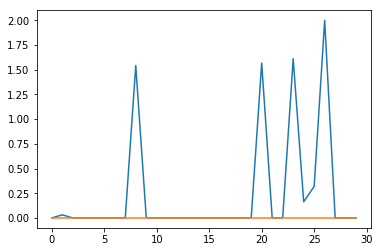

In [17]:
plt.plot(ds_scenario_annual_max.sel(lat = -23.65, lon = 125.75, method = 'nearest')[parameter].values)
plt.plot(ds_hist_annual_max.sel(lat = -23.65, lon = 125.75, method = 'nearest')[parameter].values)

In [ ]:
output_dir='/g/data/er4/zk6340/Hydro_projection/data_flood_scenario_pr/20160101-20451231'
output_file= 'test_all_return.csv'
all_return_period.to_csv((os.path.join(output_dir,output_file)), index=True)

In [ ]:
df_plot=df[df.isnull().any(axis=1)]

In [ ]:
map = Basemap(110.,-45.,155,-10.5, 
           lat_0=24.75, lon_0=134.0, lat_1=-10, lat_2=-40,
            rsphere=(6378137.00,6356752.3142),
            projection='cyl')
map.drawcoastlines()
map.drawstates()
map.drawlsmask(land_color='white', ocean_color='white')
map.drawcountries()
plt.scatter(x=df_plot['lon'], y=df_plot['lat'], marker=',', color='red')
output_file = 'test.jpeg' 
plt.savefig(os.path.join(output_dir,output_file))

In [ ]:
gev_return_period(ds_hist_annual_max.sel(lat = -24.8, lon = 147.2, method = 'nearest')[parameter].values,yT)

In [ ]:
gev_return_period(ds_scenario_annual_max.sel(lat = -24.8, lon = 147.2, method = 'nearest')[parameter].values,yT)

In [ ]:
from scipy.special import gamma, factorial #gamma function
from scipy.stats import skew
from scipy.stats import norm

In [ ]:
#Function to calculate return period: LP3 distribution
def lp3_return_period(data, T):
    xbar=np.mean(data)
    stdev=np.std(data)
    xskew=skew(data)
    zp=norm.ppf(1-1/T)
    ff=(2/xskew)*((1+(zp*xskew)/6-xskew**2/36)**3)-2/xskew
    qt=xbar+stdev*ff
    return(qt)

In [ ]:
#Function to calculate return period: EV1/Gumble distribution
def ev1_return_period(data, T):
    xbar=np.mean(data)
    stdev=np.std(data)
    ff=np.sqrt(6)/3.1416*(-0.5772-np.log(-np.log(1-1/T))) 
    qt=xbar+stdev*ff
    return(qt)

In [ ]:
lp3_return_period(ds_hist_annual_max.sel(lat = -24.8, lon = 147.2, method = 'nearest')[parameter].values,yT)

In [ ]:
ev1_return_period(ds_hist_annual_max.sel(lat = -24.8, lon = 147.2, method = 'nearest')[parameter].values,yT)

In [ ]:
-31.25,131.8
-31.5,130.6

In [ ]:
(ds_hist_annual_max.sel(lat = -23.85, lon = 125.2, method = 'nearest')[parameter].values)

In [ ]:
plt.plot(ds_hist_annual_max.sel(lat = -23.65, lon = 125.2, method = 'nearest')[parameter].values)
plt.plot(ds_scenario_annual_max.sel(lat = -23.65, lon = 125.2, method = 'nearest')[parameter].values)

In [ ]:
test_ds = xr.open_dataset('/g/data/wj02/COMPLIANT/HMINPUT/output/AUS-5/BoM/CSIRO-BOM-ACCESS1-0/historical/r1i1p1/r240x120-MRNBC-AWAP/latest/day/pr/pr_AUS-5_CSIRO-BOM-ACCESS1-0_historical_r1i1p1_r240x120-MRNBC-AWAP_v1_day_19760101-20051231.nc')

In [ ]:
(test_ds.sel(lat = -20.05, lon = 118.8, method = 'nearest')[parameter].values)

In [ ]:
test_ds = xr.open_dataset('/g/data/wj02/COMPLIANT/HMINPUT/output/AUS-5/BoM/MIROC-MIROC5/historical/r1i1p1/r240x120-MRNBC-AWAP/latest/day/pr/pr_AUS-5_MIROC-MIROC5_historical_r1i1p1_r240x120-MRNBC-AWAP_v1_day_19600101-20051231.nc')

In [ ]:
plt.plot(ds_hist_annual_max.sel(lat = -31.6, lon = 130.6, method = 'nearest')[parameter].values)

In [15]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import LogNorm
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes #put inset plot
%matplotlib inline

In [ ]:
map = Basemap(110.,-45.,155,-10.5, 
           lat_0=24.75, lon_0=134.0, lat_1=-10, lat_2=-40,
            rsphere=(6378137.00,6356752.3142),
            projection='cyl')
map.drawcoastlines()
map.drawstates()
map.drawlsmask(land_color='Linen', ocean_color='white')
map.drawcountries()
map.drawparallels(np.arange(-43,-10,10),labels=[1,0,0,0])
map.drawmeridians(np.arange(110,155,10),labels=[0,0,0,1])
plt.scatter(125.2,-23.85, marker = '*', color = 'red')

In [ ]:
grid_cells.lat[i]

In [ ]:
grid_cells.lon[i]

In [ ]:
yT_point

In [ ]:
all_return_period

In [ ]:
hist_yT_point

In [ ]:
grid_cells

In [ ]:
data_test = ds_hist_annual_max.sel(lat = -23.85, lon = 125.2, method = 'nearest')[parameter].values

In [ ]:
data_test

In [ ]:
data_test = ds_scenario_annual_max.sel(lat = -23.85, lon = 125.2, method = 'nearest')[parameter].values

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
plt.plot(ds_hist_annual_max.sel(lat = -23.85, lon = 125.2, method = 'nearest')[parameter].values)
plt.plot(ds_scenario_annual_max.sel(lat = -23.85, lon = 125.2, method = 'nearest')[parameter].values)

In [ ]:
gev_return_period(data_test, 20)

In [ ]:
#Function to calculate return period: LP3 distribution
def lp3_return_period(data, T):
    xbar=np.mean(data)
    stdev=np.std(data)
    xskew=skew(data)
    zp=norm.ppf(1-1/T)
    ff=(2/xskew)*((1+(zp*xskew)/6-xskew**2/36)**3)-2/xskew
    qt=xbar+stdev*ff
    return(qt)

In [ ]:
lp3_return_period(data_test, 20)

In [ ]:
#Function to calculate return period: EV1/Gumble distribution
def ev1_return_period(data, T):
    xbar=np.mean(data)
    stdev=np.std(data)
    ff=np.sqrt(6)/3.1416*(-0.5772-np.log(-np.log(1-1/T))) 
    qt=xbar+stdev*ff
    return(qt)

In [ ]:
ev1_return_period(data_test, 20)

In [ ]:
caluster_flood_indicator=[]
for val in enumerate(values):   
#for val in enumerate(values[0]):  
    #Change in mean
    change_daily_mean = percentage_change(parameter, val[1][0], val[1][1], val[1][2], 'Mean', hist_end, hist_st, yr_end, yr_st)

    #Change in max
    change_daily_max = percentage_change(parameter, val[1][0], val[1][1], val[1][2], 'Max', hist_end, hist_st, yr_end, yr_st)  
    
    #Change in return period
    # Annual Max - for historical period
    filename_hist_annual_max = get_file(parameter,val[1][0],'historical',val[1][2],'Annual_Max',hist_end,hist_st)
    ds_hist_annual_max = xr.open_dataset(os.path.join(dir_in,filename_hist_annual_max))
    # Annual Max - for scenario period
    filename_scenario_annual_max = get_file(parameter,val[1][0],val[1][1],val[1][2],'Annual_Max',yr_end,yr_st)
    ds_scenario_annual_max = xr.open_dataset(os.path.join(dir_in,filename_scenario_annual_max))  
    # calculate retrun period for the historical period
    all_yT = []
    for i in range (0, len(grid_cells)): 
        hist_yT_point = gev_return_period(ts_data(ds_hist_annual_max, grid_cells.lat[i], grid_cells.lon[i], parameter), yT)
        scenario_yT_point = gev_return_period(ts_data(ds_scenario_annual_max, grid_cells.lat[i], grid_cells.lon[i], parameter), yT)       
        yT_point = {'hist_yT':hist_yT_point,'future_yT':scenario_yT_point}
        all_yT.append(yT_point)
    all_return_period = pd.DataFrame(all_yT)   
    change_return_period = ((all_return_period['future_yT'].mean()-all_return_period['hist_yT'].mean())*100)/all_return_period['hist_yT'].mean()   
    dd = {'GCM':val[1][0],'Bias Correction':val[1][2],'Emission':val[1][1],'Change in Daily Mean':change_daily_mean,'Change in daily Max':change_daily_max, 'Change in Return Period':change_return_period}
    cluster_flood_indicator.append(dd)
    break # just want to check one loop/one ensemble

In [ ]:
cluster_flood_indicator

In [ ]:
values[10][0]

#### Slow code

In [ ]:
cluster_flood_indicator=[]
for val in enumerate(values):   
#for val in enumerate(values[0]):  
    #Change in mean
    change_daily_mean = percentage_change(parameter, val[1][0], val[1][1], val[1][2], 'Mean', hist_end, hist_st, yr_end, yr_st)

    #Change in max
    change_daily_max = percentage_change(parameter, val[1][0], val[1][1], val[1][2], 'Max', hist_end, hist_st, yr_end, yr_st)  
    
    #Change in return period
    # Annual Max - for historical period
    filename_hist_annual_max = get_file(parameter,val[1][0],'historical',val[1][2],'Annual_Max',hist_end,hist_st)
    ds_hist_annual_max = xr.open_dataset(os.path.join(dir_in,filename_hist_annual_max))
    # calculate retrun period for the historical period
    hist_yT = []
    for i in range (0, len(grid_cells)): 
        hist_yT_point = gev_return_period(ts_data(ds_hist_annual_max, grid_cells.lat[i], grid_cells.lon[i], parameter), yT)
        hist_yT.append(hist_yT_point)
    hist_yT_mean = pd.DataFrame(hist_yT).mean()[0]
    # Annual Max - for scenario period
    filename_scenario_annual_max = get_file(parameter,val[1][0],val[1][1],val[1][2],'Annual_Max',yr_end,yr_st)
    ds_scenario_annual_max = xr.open_dataset(os.path.join(dir_in,filename_scenario_annual_max))
    # calculate retrun period for the scenario period
    scenario_yT = []
    for j in range (0, len(grid_cells)): 
        scenario_yT_point = gev_return_period(ts_data(ds_scenario_annual_max, grid_cells.lat[j], grid_cells.lon[j], parameter), yT)
        scenario_yT.append(scenario_yT_point)
    scenario_yT_mean = pd.DataFrame(scenario_yT).mean()[0]
    change_return_period = ((scenario_yT_mean-hist_yT_mean)*100)/hist_yT_mean
    
    dd = {'GCM':val[1][0],'Bias Correction':val[1][2],'Emission':val[1][1],'Change in Daily Mean':change_daily_mean,'Change in daily Max':change_daily_max, 'Change in Return Period':change_return_period}
    cluster_flood_indicator.append(dd)
    break # just want to check one loop/one ensemble

#### Mean of change

In [ ]:
cluster_flood_indicator=[]
for val in enumerate(values):   
#for val in enumerate(values[0]):  
    #Change in mean
    change_daily_mean = percentage_change(parameter, val[1][0], val[1][1], val[1][2], 'Mean', hist_end, hist_st, yr_end, yr_st)

    #Change in max
    change_daily_max = percentage_change(parameter, val[1][0], val[1][1], val[1][2], 'Max', hist_end, hist_st, yr_end, yr_st)  
    
    #Change in return period
    # Annual Max - for historical period
    filename_hist_annual_max = get_file(parameter,val[1][0],'historical',val[1][2],'Annual_Max',hist_end,hist_st)
    ds_hist_annual_max = xr.open_dataset(os.path.join(dir_in,filename_hist_annual_max))
    # Annual Max - for scenario period
    filename_scenario_annual_max = get_file(parameter,val[1][0],val[1][1],val[1][2],'Annual_Max',yr_end,yr_st)
    ds_scenario_annual_max = xr.open_dataset(os.path.join(dir_in,filename_scenario_annual_max))  
    # calculate retrun period for the historical period
    change_yT = []
    for i in range (0, len(grid_cells)): 
        hist_yT_point = gev_return_period(ts_data(ds_hist_annual_max, grid_cells.lat[i], grid_cells.lon[i], parameter), yT)
        scenario_yT_point = gev_return_period(ts_data(ds_scenario_annual_max, grid_cells.lat[i], grid_cells.lon[i], parameter), yT)
        diff_yT = ((scenario_yT_point-hist_yT_point)*100)/hist_yT_point
        change_yT.append(diff_yT)
    change_return_period = pd.DataFrame(change_yT).mean()[0]   
    dd = {'GCM':val[1][0],'Bias Correction':val[1][2],'Emission':val[1][1],'Change in Daily Mean':change_daily_mean,'Change in daily Max':change_daily_max, 'Change in Return Period':change_return_period}
    cluster_flood_indicator.append(dd)
    break # just want to check one loop/one ensemble

In [ ]:
cluster_flood_indicator